# Initial setup
Only if you run from Google Colab run those 2 cells to sync with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TF4AML/

/content/drive/MyDrive/TF4AML


# The Transformer Architecture

This notebook will guide you through the building blocks of the Transformer model, one of the last two years' most influential architecture. The Transformer design has continued to outperform benchmarks since the publication of the Vaswani et al. paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) in 2017, particularly in the field of natural language processing. Transformers with an enormous number of parameters may generate long, compelling writings, opening up new AI application sectors. It is crucial to understand how the Transformer architecture works and to have developed it yourself, which we will do in this notebook.

In [1]:
import torch
from torch.nn.functional import softmax
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy
from copy import deepcopy
import numpy as np 
import math
import scipy.io
import os
import random


## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic=True


### The Attention Mechanism

In the last several years, particularly in sequence tasks, a new collection of layers in neural networks known as the attention mechanism has garnered a lot of attention. The attention mechanism defines a weighted average of (sequence) items, with the weights dynamically computed based on an input query and the elements' keys. So what precisely does this mean? The objective is to average out the features of multiple elements. We want to weight the elements according to their actual values rather than giving each equal weight.

An attention mechanism, in particular, usually has four components that must be specified:

* **Query**: The query is a feature vector that identifies the elements in the sequence that we are searching for, or perhaps want to pay attention to.
* **Keys**: We have a key, which is also a feature vector, for each input element. This feature vector essentially explains what the element "offers" or when it might be significant. The keys should be created so that, based on the query, we can identify the elements we wish to pay attention to.
* **Values**: There is also a value vector available for each input element. Specifically, we want to average over this feature vector.
* **Score function**: A scoring function called $f_{attn}$ must be specified in order to rate the items that we want to pay attention to. The query and a key are entered into the score function, which returns the attention weight and score for the query-key pair. It is typically used using straightforward similarity metrics, such as a dot product or a small MLP.

A softmax is used to calculate the average's weights across all scoring function outputs. As a result, we give greater weight to value vectors whose corresponding key is most comparable to the query.


$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Here is an example of attention over a sequence:

<center width="100%" style="padding:25px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/attention_example.svg?raw=1" width="750px"></center>

Every word has a key and a value associated. The score function compares the query to all the keys to compute the weights. The values of the words are averaged by the attention weights. 

Self-attention is the term for the attention applied inside the Transformer architecture. Each sequence element in self-attention gives a key, value, and query. We execute an attention layer for each element, which checks the similarity of the keys of all the sequence members based on the element's query and returns a unique, averaged value vector for each element. 

### Scaled Dot Product Attention  (***1 POINT***)

Scaled dot product attention is the central idea of self-attention. Our objective is to develop an attention mechanism that allows each element in a sequence to pay attention to any other while maintaining compute efficiency.The input to the dot product are the queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ with $T$ as the sequence length, $d_k$ and $d_v$ are the hidden dimensionality for $Q$, $K$ and $V$.

We compute the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ produces a matrix with dimension $T\times T$ by doing the dot product for every distinct pair of queries and keys. The attention logits for a particular element $i$ to every other element in the sequence are shown in each row. We use a softmax on these and multiply by the value vector to get a weighted mean (the weights being determined by the attention). The computation graph below provides another viewpoint on this attention technique.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/scaled_dot_product_attn.svg?raw=1" width="210px"></center>

$1/\sqrt{d_k}$, the scaling factor, is crucial to maintain an appropriate variance of attention values after initialization. As a result, $Q$ and $K$ may also have a variance of close to $1$. Keep in mind that we initialize our layers with the purpose of having equal variance across the model. Dot products over two vectors with variances $\sigma^2$, however, produce scalars with $d_k$-times larger variance: 

$$q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k$$


The optional masking of particular entries in the attention matrix is shown by the block labeled "Mask (opt.)" in the diagram above. When calculating the attention values, we pad the sentences to the same length and mask out the padding tokens.

---

Following the description we just made about scale-dot product, complete the Attention class below.

In [2]:
class Attention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):

        '''
        add here the code regarding the argument of the softmax function as defined above
        '''
        d=query.size(-1)
        attn=torch.matmul(query, key.transpose(-2, -1))/(math.sqrt(d))
        
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        
        '''
        Computed attn, calculate the final output of the attention layer
        '''
        output=torch.matmul(attn, value)
        return output, attn


Do not modify the code below. 

The following example about the Attention function you just implemented does not include the mask, which instead will be used later in the MultiHeadAttention class. 

We generate here some random $Q$ $K$ and $V$ to procude some attention outputs.

In [3]:
torch.manual_seed(0)

seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
attention = Attention()
values, attn = attention(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attn)

Q
 tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684],
        [-1.0845, -1.3986]])
K
 tensor([[ 0.4033,  0.8380],
        [-0.7193, -0.4033],
        [-0.5966,  0.1820]])
V
 tensor([[-0.8567,  1.1006],
        [-1.0712,  0.1227],
        [-0.5663,  0.3731]])
Values
 tensor([[-0.9328,  0.8123],
        [-0.9093,  0.3966],
        [-0.9970,  0.3056]])
Attention
 tensor([[0.6291, 0.2395, 0.2425],
        [0.1387, 0.4749, 0.4975],
        [0.0842, 0.6800, 0.3469]])


### Multi-Head Attention  (***2 POINTS***)

A network can pay attention to a sequence thanks to scaled dot product attention. A single weighted average, however, is not a viable choice for a sequence element because it frequently wishes to pay attention to several separate characteristics. For this reason, we expand the attention methods to include numerous heads, or several query-key-value triplets on the same features. We specifically change a query, key, and value matrix into $h$ sub-queries, sub-keys, and sub-values, which we then independently pass through the scaled dot product attention. The heads are then combined with a final weight matrix by concatenating them. 

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer. We can visually see it here:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/multihead_attention.svg?raw=1" width="230px"></center>

Set the feature map, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ (with $B$ as the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The weights $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding queries, keys, and values of the input. The final result is produced by multiplying the concatenated output by the weight matrix $W^{0}$

---

Complete the MultiHeadAttention class below.

In [4]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):

        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k. 
        # The query is given as example, you should do the same for key and value  
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        '''
        add your code here
        '''
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        # 2) Apply attention on all the projected vectors in batch.
        '''
        add your code here
        '''        
        x, attn = self.attention(query, key, value, mask)
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)

        if return_attention:
            return self.attn_ff(x), self.attn

        return self.attn_ff(x)


Do not change the following code.

In [5]:
torch.manual_seed(0)
np.random.seed(0)

num_heads = 8
d_model = 512


self_attn = MultiHeadAttention(num_heads, d_model)


x = torch.tensor(np.random.rand(1, 7,512)).float()

attn_out = self_attn(x, x, x)
attn_out

tensor([[[ 0.1963, -0.0791,  0.0207,  ..., -0.1688,  0.1161,  0.1932],
         [ 0.1876, -0.0731,  0.0135,  ..., -0.1666,  0.1163,  0.1807],
         [ 0.1647, -0.0816,  0.0357,  ..., -0.1614,  0.0965,  0.2349],
         ...,
         [ 0.2222, -0.1297,  0.0181,  ..., -0.1854,  0.0964,  0.2300],
         [ 0.1962, -0.1470,  0.0295,  ..., -0.2274,  0.0817,  0.2286],
         [ 0.2229, -0.1208,  0.0031,  ..., -0.2206,  0.1585,  0.2397]]],
       grad_fn=<ViewBackward0>)

The fact that the multi-head attention is permutation-equivariant with respect to its inputs is an important aspect of the framework. This means that if we switch the first and second items of the input sequence, the output will still be precisely the same. As a result, the multi-head attention really considers the input as a collection of items rather than a sequence. This characteristic is what makes the Transformer architecture and the multi-head attention block so potent and versatile.

### The Encoder-Decoder Blocks (4 POINTS)

The paper's original transformer is a neural machine translation model. We could teach it to translate a sentence, for instance, into French. Encoder-decoder architecture is used by the transformer. An input sentence is processed by the encoder to extract features, which are then used by the decoder to create an output sentence (translation). The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/transformer_architecture.svg?raw=1" width="400px"></center>

Let's examine the Encoder block in more depth. The Decoder is easy to use once you comprehend this.

The encoder is made up by $N$ sequentially applied identical blocks. Using $x$ as the input, a Multi-Head Attention block is first applied. Using a residual connection, the output is added to the original input, and the sum is then subjected to a subsequent layer normalization. Formally, it computes:

 $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). 
 
To enable a smooth gradient flow across the model, the residual connections are essential. Furthermore, the information about the original sequence is lost in the absence of residual connections.

Faster training is made possible by the layer normalization, which also offers minor regularization. Additionally, it makes sure that each element in the sequence has features that are of a similar magnitude.

A small fully connected feed-forward network is also included to the model in addition to the Multi-Head Attention, and it is applied to each position individually and identically. One way to describe the complete transformation, including the residual connection, is as follows:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

In addition to the layers we just discussed, a dropout layer is added in the MLP, on the output of the MLP and Multi-Head Attention as regularization. 

Regarding the masking in the decoder block, the target mask is needed since the transformer decoder has all the target tokens as input during training. However, it should produce output related to what happened before the current timestep, and that's why the target mask is introduced. 

Knowing what the target mask is used for, you should now be able to add it in the correct attention of the decoder. (hint: the two masks are used separately and there is no need to change them.) 


Add your solution to the EncoderBlock and DecoderBlock classes.

In [6]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None): 
        # Self_attention part (use self.norm1)
        '''
        Add your code here
        '''
        attn_1 = self.self_attn(x,x,x)
        norm_1_out = self.norm1(x+self.dropout(attn_1))
        # MLP part (use self.norm2)
        '''
        Add your code here
        '''
        mlp_out = self.linear_net(norm_1_out)
        norm_2_out = self.norm2(norm_1_out+self.dropout(mlp_out))
        x = norm_2_out
        return x


In [7]:
class DecoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Self Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)
        # Attention Layer
        self.src_attn = MultiHeadAttention(num_heads, input_dim)
        
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask): 
        # Self-Attention part (use self.norm1)
        '''
        Add your code here
        '''
        attn_1 = self.self_attn(x,x,x,tgt_mask)
        norm_1_out = self.norm1(x + attn_1)
        # Attention part (use self.norm2)
        # Recall that memory is the output of the encoder and replaces x as
        # the key and value in the attention layer
        '''
        Add your code here
        '''
        attn_2 = self.src_attn(norm_1_out,memory,memory)
        norm_2_out = self.norm2(self.dropout(attn_2)+norm_1_out)
        # MLP part (use self.norm3)
        '''
        Add your code here
        '''
        mlp = self.linear_net(norm_2_out)
        norm_3_out = self.norm3(self.dropout(mlp)+norm_2_out)
        x = norm_3_out
        return x


### Positional Encoding  (***2 POINTS***)

Position is crucial for deciphering the input words in activities like language understanding. Therefore, the input characteristics can be used to add the positional information. Even if we learned an embedding for every possible place, this wouldn't apply to input sequence lengths with dynamic input. Therefore, using feature patterns that the network can recognize from the features and maybe generalize to longer sequences is a better alternative.

Following the solution of Vaswani et al., the positional encoding is defined as: 

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. The position information is made up of these values, which are added to the initial input features and concatenated for all hidden dimensions.

Complete the initialization of the PositionalEncoding class.

In [8]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        '''
        Add your code here
        '''
        for row in range(max_len):
          for col in range(d_model):
            if col%2 == 0:
              pe[row][col] = math.sin(row/(10000**(col/d_model)))
            else:
              pe[row][col] = math.cos(row/(10000**((col-1)/d_model)))
        pe = pe.unsqueeze(0) # the final dimension is (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


We may display the positional encoding below to better comprehend it. We will create a sequence-based image of the positional encoding over concealed dimensions. As a result, each pixel indicates the modification of the input feature that we do in order to encode a certain position. Here's how to do it:

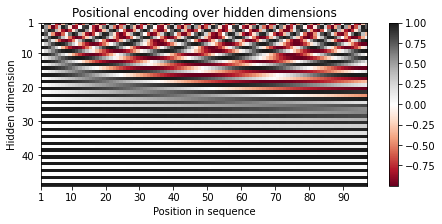

In [9]:
encod_block = PositionalEncoding(d_model=48, dropout=0.1, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

The sine and cosine waves with various wavelengths that encode the position in the hidden dimensions are easily visible. To better understand the pattern, we can examine the sine/cosine wave for each hidden dimension separately. The positional encoding for the hidden dimensions is shown in the image below.

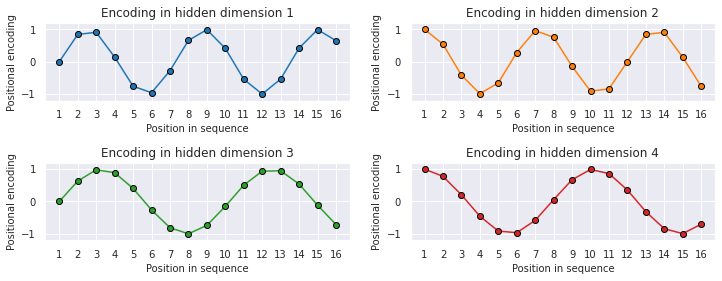

In [10]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

### Transformer Network  (***2 POINTS***)
Everything we've talked about up to this point is summarized in the class Transformer below. In this case, initial input processing positional encoding and the encoder-decoder blocks are all necessary for you to formulate your answer.

In [11]:
class Transformer(nn.Module):
    def __init__(self, enc_inp_size, dec_inp_size, dec_out_size, N=6,
                   d_model=512, dim_feedforward=2048, num_heads=8, dropout=0.1,
                   mean=[0,0],std=[0,0]):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.N = N
        self.mean = mean
        self.std = std
        self.enc_inp_size = enc_inp_size
        self.dec_inp_size = dec_inp_size
        self.dec_out_size = dec_out_size
        
        self.encoder = nn.ModuleList([deepcopy(
            EncoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.decoder = nn.ModuleList([deepcopy(
            DecoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.pos_enc = PositionalEncoding(d_model, dropout)
        self.pos_dec = PositionalEncoding(d_model, dropout)
        self.src_embed = nn.Linear(enc_inp_size, d_model)
        self.tgt_embed = nn.Linear(dec_inp_size, d_model)
        self.out = nn.Linear(d_model, dec_out_size)
        
        self.init_weights()


    def forward(self, src, trg, src_mask, trg_mask):
        
        # First part of the forward pass: embedding and positional encoding 
        # for both the source and target
        '''
        Add here your code
        '''
        src_embedding = self.src_embed(src)
        trg_embedding = self.tgt_embed(trg)
        src_pos_encoding = self.pos_enc(src_embedding)
        trg_pos_encoding = self.pos_dec(trg_embedding)

        # Second part of the forward pass: the encoder and decoder layers. 
        # Look at the arguments of the forward pass of the encoder and decoder 
        # and recall that the encoder output is used as the memory in the decoder.
        '''
        Add here your code
        '''
        encoder_in = src_pos_encoding
        decoder_in = trg_pos_encoding
        
        encoder_input = encoder_in 
        for layer in self.encoder:
          encoder_out = layer(encoder_input, src_mask) 
          encoder_input = encoder_out
          
        decoder_input = decoder_in
        for layer in self.decoder:
          decoder_out = layer(decoder_input,encoder_out,src_mask,trg_mask)
          decoder_input = decoder_out
      
        output = self.out(decoder_out)

        return output
    
    
    # Initialize parameters with Glorot / fan_avg. 
    def init_weights(self):
        for p in self.encoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.decoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_enc.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_dec.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.src_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.tgt_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.out.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)



### Optimizer  (***1 POINT***)

Here we select same **optimizer** proposed into original Transformer paper. 

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [12]:
class SqrtScheduler(torch.optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, factor, model_size, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        self.factor = factor
        self.model_size = model_size
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch+1)
        return [base_lr + lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        '''
        Add here your code
        '''
        a=self.factor/(np.sqrt(self.model_size))
        b_1=1/np.sqrt(epoch)
        b_2=epoch*pow(self.warmup,-3/2)
        b=min(b_1,b_2)
        lr_factor=a*b
        return lr_factor

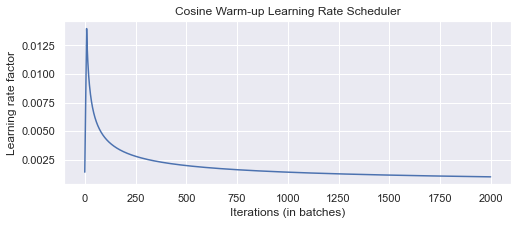

In [13]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = torch.optim.Adam([p], lr=0)

lr_scheduler = SqrtScheduler(optimizer=optimizer, factor = 1.0, model_size = 512, warmup=10, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e+1) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

The code below is used as a sanity check to verify the good implementation of your code. Do not change what follows.

In [14]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))


enc_input_size = 2
dec_input_size = 3
dec_output_size = 3


num_heads = 8
d_model = 512
dim_feedforward = 2048
dropout = 0.1
preds_num = 8

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

torch.manual_seed(0)
tf = Transformer(enc_input_size, dec_input_size, dec_output_size, N=6, 
            d_model=d_model, dim_feedforward=dim_feedforward, 
            num_heads=num_heads, dropout=dropout).to(device)

Current device: cuda - Type: NVIDIA GeForce RTX 2070


In [15]:
np.random.seed(0)

batch = torch.tensor(np.random.rand(1, 8,4)).float().to(device)
inp = batch[:,1:,0:2].to(device) 
target = batch[:,:-1,2:].to(device) 

# We create a third mask channel to append to the 2 speeds. 
# This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
# Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
#              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
target = torch.cat((target, target_c), -1)
# Final decoder input is the concatenation of them along temporal dimension
dec_inp = torch.cat((start_of_seq, target), 1)

# Source attention is enabled between all the observed input (mask elements are setted to 1)
src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
# For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
# The mask is changed dinamically to use teacher forcing learning
trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

# Source, target and corresponding attention mask are passed to the model for the forward step
tf.eval()
pred = tf(inp.float(), dec_inp.float(), src_att, trg_att)
pred

tensor([[[1.4025, 0.1318, 2.2073],
         [1.4107, 0.1384, 2.2111],
         [1.4233, 0.1524, 2.2139],
         [1.4406, 0.1682, 2.2192],
         [1.4553, 0.1758, 2.2197],
         [1.4646, 0.1773, 2.2245],
         [1.4616, 0.1686, 2.2236],
         [1.4464, 0.1582, 2.2220]]], device='cuda:0', grad_fn=<ViewBackward0>)

---

This notebook was created by Luca Franco and Alessandro Flaborea.